一、变分自编码器生成MNIST 手写数字（结合代码描述实现步骤以及提交下面要求提交的结果）

推荐使用高斯分布随机初始化模型参数，可以避免一部分模式坍塌问题。
1、模型架构：
① 编码器（全连接层）：
输入图片维度：784 (28 × 28)
输出层维度（ReLU）：400
② 生成均值（全连接层）：
输入层维度：400
输出层维度：20
③ 生成标准差（全连接层）：
输入层维度：400
输出层维度：20
④ 使用均值和标准差生成隐变量z
⑤ 解码器（全连接层）：
输入维度：20
隐藏层维度（ReLU）：400输
出层维度（Sigmoid）：784
训练完网络，需要提交重构损失和KL散度的随迭代次数的变化图，以及10 张
生成的手写数字图片。

导入库

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


用一个类去封装并且定义VAE模型（实现上述模型架构）

采用了重参数化技巧：z=μ+σ⋅ϵ，σ=exp(0.5⋅logvar)，ϵ∼N(0,I)。主要目的为：保留可微性：使得模型在采样隐变量 z 时仍然可以进行反向传播。引入随机性：通过标准正态分布的噪声 𝜖来保持采样过程的随机性，使得 VAE 的隐变量具有生成分布的能力。

In [29]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # 编码器
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        
        # 解码器
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
    
    #将输入数据压缩为隐变量的均值和对数方差
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)
    
    #采用了重参数化技巧
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

定义损失函数

损失函数由重构误差和KL散度构成
BCE=-sum(i=1->N)(XilogXi'+(1-Xi)log(1-Xi')) Xi':重构生成的数据 ,N=28x28
KL 散度可以强制隐变量分布接近标准正态分布，形成一个有规律的潜在空间结构。


$$
\text{KLD} = -\frac{1}{2} \sum_{j=1}^{M} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
$$

$$
\mu: \text{编码器生成的隐变量分布的均值向量。}
$$

$$
\sigma^2 = \exp(\text{logvar}): \text{隐变量分布的方差，其中 logvar 是对数方差。}
$$

$$
M: \text{隐变量的维度（在这个模型中为 20）。}
$$


$$
\text{BCE} = -\sum_{i=1}^{N} \left[ x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i) \right]
$$


In [30]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')#sum表示返回所有损失的和，mean表示返回平均值
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

加载数据集，并使用数据加载器，transform：transforms.ToTensor() 将输入图像转换为 PyTorch 张量，并将像素值从 0-255（整型）范围缩放到 0-1（浮点型）范围。对于灰度图像（单通道），它将生成一个形状为 (1, H, W) 的张量；对于 RGB 图像，它将生成 (3, H, W) 的张量，其中 H 和 W 为图像的高度和宽度。transforms.Lambda(lambda x: x.view(-1)) 是一个自定义转换操作。它对输入的张量 x 应用 view(-1) 操作，将其展平成一维向量。view(-1) 会自动计算并调整张量的大小，使得所有元素都在一个一维张量中。比如说：对于 28x28 的灰度图像（例如 MNIST 数据集），在应用 ToTensor() 后张量形状为 (1, 28, 28)。经过 view(-1) 处理后，张量形状变成 (784,)。

In [31]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

初始化模型，优化器，定义模型超参数

In [32]:
# 初始化模型、优化器
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# 训练模型
num_epochs = 100
reconstruction_losses = []
kl_losses = []

开始训练

In [33]:
for epoch in range(num_epochs):
    vae.train()#nn.Module内置
    train_loss = 0
    reconstruction_loss = 0
    kl_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):#（data,_）因为是无监督学习所以没有标签用_
        data = data.to(device)#将数据迁移到GPU
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)#调用forward()函数
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        reconstruction_loss += bce.item()
        kl_loss += kld.item()
        optimizer.step()
    
    reconstruction_losses.append(reconstruction_loss / len(train_loader.dataset))
    kl_losses.append(kl_loss / len(train_loader.dataset))
    
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}, BCE: {reconstruction_loss / len(train_loader.dataset)}, KLD: {kl_loss / len(train_loader.dataset)}")

Epoch 1, Loss: 165.3020716796875, BCE: 150.12601051432293, KLD: 15.176061004479726
Epoch 2, Loss: 121.69891692708333, BCE: 99.14765349934896, KLD: 22.551263517252604
Epoch 3, Loss: 114.66297008463542, BCE: 90.51297451171875, KLD: 24.14999569091797
Epoch 4, Loss: 111.74801271158854, BCE: 87.03184103190104, KLD: 24.716171752929686
Epoch 5, Loss: 109.97101922200521, BCE: 85.02163464355469, KLD: 24.949384366861977
Epoch 6, Loss: 108.8215818359375, BCE: 83.74659449869792, KLD: 25.074987268066405
Epoch 7, Loss: 107.9133006998698, BCE: 82.75955424804687, KLD: 25.153746435546875
Epoch 8, Loss: 107.27075862630208, BCE: 82.05127303059896, KLD: 25.219485298665365
Epoch 9, Loss: 106.79034085286459, BCE: 81.5048848795573, KLD: 25.285456022135417
Epoch 10, Loss: 106.3172982421875, BCE: 81.01563967285156, KLD: 25.301658557128906
Epoch 11, Loss: 105.98319166666667, BCE: 80.65520839029948, KLD: 25.327983093261718
Epoch 12, Loss: 105.67151702473959, BCE: 80.29949213867188, KLD: 25.372024719238283
Epoch 

Epoch 100, Loss: 100.56256595052083, BCE: 75.24932430826823, KLD: 25.313241418457032


训练完成后，输出重构损失和KL散度的随迭代次数的变化图，以及10 张生成的手写数字图片。

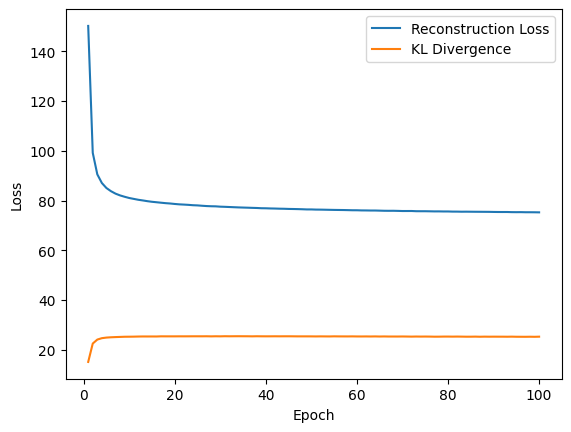

In [34]:
# 绘制损失变化图
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label="Reconstruction Loss")
plt.plot(range(1, num_epochs + 1), kl_losses, label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

输出样本图像

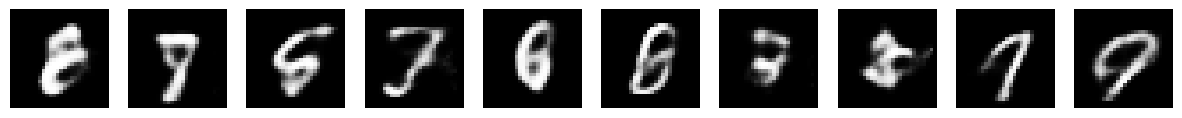

In [35]:
# 生成样本图像
vae.eval()
with torch.no_grad():
    z = torch.randn(10, 20).to(device)  # 从标准正态分布采样
    sample = vae.decode(z).view(-1, 28, 28).cpu()#从GPU转移到CPU
    fig, ax = plt.subplots(1, 10, figsize=(15, 2)) #fig是图像的容器，ax是包含10个子图的数组
    for i in range(10):
        ax[i].imshow(sample[i].cpu().numpy(), cmap='gray')#cmap='gray' 表示使用灰度颜色映射来显示图像。.numpy() 将 PyTorch 张量转换为 NumPy 数组，以便 Matplotlib 可以处理。
        ax[i].axis('off') #这一行隐藏了每个子图的坐标轴，简化图像展示。
    plt.show()